# I. Implementación K-means
K-means
    Elegir instacias del dataset como centroides iniciales
    Distirbuir puntos del dataset a los centroides
    Calcular la media de las distancias respecto de los puntos
    Se recalculaba el centroide 
    Repetir hasta que no haya cambios
    
Estaría bien usar la misma interfaz que sckikit learn
Kmeans = Kmeans(K=5)
Kmeans.fit(X)
Kmeans.predict(X)

Tenemos un conjunto de datos, eliges el numero de clusters (n_clusters), asignas los centroides a unos datos aleatoriamente (init -> puntos aleatorios del dataset), y después asignas los datos a los clusters (asignar_clusters). Después hay que computar los nuevos centroides en un bucle y volver a asignar los clusters hasta que se cumpla la condición de parada.

In [531]:
import sklearn
from sklearn.cluster import KMeans

kmeans = KMeans()
#kmeans.fit(X)
#kmeans.predict(X)

In [532]:
import time
import numpy as np
import math
from math import dist
import statistics as s
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

In [533]:
x, y = make_blobs()
print(x.shape[1])
print("EQUIS: \n", x)
print("Y: \n", y)

2
EQUIS: 
 [[-0.52489563 -4.4105829 ]
 [-0.03952312 -5.71419363]
 [-1.66588086 -4.85924923]
 [-3.34137817  8.50300963]
 [-1.88689466  6.88022694]
 [-1.59540933  8.13159437]
 [-3.74389276  8.18322574]
 [-1.32423325  8.07060074]
 [-1.9036617   7.13016907]
 [ 1.62371318 -3.48953102]
 [-1.1488741  -4.65404616]
 [ 0.17759427 -3.23327341]
 [-2.96036847 -5.7121433 ]
 [-0.70715573 -5.32999129]
 [-1.18670902  8.05279831]
 [ 1.24862883 -4.77096854]
 [-1.07302476  9.55002363]
 [ 0.18159942 -6.47400328]
 [-1.11679894  8.46091107]
 [ 0.61442238 -4.41972621]
 [-0.5512724  -3.03835039]
 [-1.3320892  -4.80361481]
 [-0.4042011  -5.59065173]
 [-1.00984475 -2.16808802]
 [-0.29554888 10.15378883]
 [-2.94809798  9.49450491]
 [-0.04580219 -4.94553271]
 [ 1.82444712 -4.5257797 ]
 [ 1.04570805 -5.82089954]
 [-0.24829184 -5.16868885]
 [-0.56578268 -3.60979313]
 [-2.79447748  8.7449571 ]
 [ 0.55077401 -2.09674512]
 [-1.9032121  -5.44576822]
 [-0.46840553  8.5461935 ]
 [ 0.96242855 -5.28366052]
 [ 0.11377158 -6.

In [534]:
len(x)

100

In [535]:
class KMeans_Ours():
    def __init__(self, n_clusters=8, max_iter=100, random_state=55):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.iter = 0
        self.random_state = random_state
        
        self.X= []
        
        self._centroids= []
        self._inertia=[]
        self._labels=[]
        self.history = {'iteration': [],
                        'centroids':  [],  
                        'labels' : [],
                        'inertia':  []
                        }
    
    def fit(self, X):
        """Este método entrena el modelo con el dataset proporcionado, aplicando el algoritmo de asignación de centroides"""
        self.X = X
        self._assign_centroids()
        self._assign_labels()
        # print("centroides iniciales: ", self._centroids)
        while not self._stop(): # si se llega a max iter o si centroides no cambian (con último valor de self.history), una u otra
            self._add_history_step() 
            # con esto podemos hacer un gráfico (no se pide pero quedaría rechulón)
            
            self._update_centroides()
            # print("history: ", self.history['centroids'][self.iter])
            self._assign_labels()
            
            self.iter += 1
            
    def return_centroids(self):
        return self._centroids
    
    def return_labels(self):
        return self._labels
    
    def predict(self, X):
        # contemplar posibilidad de triangulación
        predictions = []
        for row in X:
            min_distance = math.inf
            nearest_centroid = None
            for centroid_label in range(self.n_clusters):
                distance = dist(row, self._centroids[centroid_label])
                # print("distancia entre", row, "y", self._centroids[centroid_label], "es: ", distance, "con label", centroid_label)
                # print("distancia: ", distance, "\nmin_distancia: ", min_distance)
                if distance < min_distance:
                    # print("dentro if")
                    min_distance = distance
                    nearest_centroid = centroid_label
            predictions.append(nearest_centroid)
        return predictions
    
    def _assign_centroids(self):
        # utilizar el módulo random de numpy para asignar los centroides: check
        # sólo para la primera iteración (asignación de centroides iniciales): check
        # un centroide a la misma posición dato aleatoriamente 
        # con replace = false nos aseguramos de que no se repita el mismo valor para dos centroides diferentes,
        # de forma que todos los centroides tomen coordenadas distintas
        np.random.seed(self.random_state)
        c_index = np.random.choice(list(range(0, len(self.X))), size = self.n_clusters, replace = False)
        # print(c_index)
        for i in c_index:
            self._centroids.append(self.X[i])
            # print("centroide ",i, ": ", self.X[i])
        # print("asignación inicial de centroides en kmeans ours ", self._centroids)
        # asignar valores de los datos a los que equivalen esas posiciones en la tabla a los "centroides"        
    
    def _assign_labels(self):
        # función para asignar los datos a un centroides
        # linalg.norm -> normaliza los vectores, no calcula distancias como tal; no es lo que buscamos
        self._inertia = []
        self._labels = []
        
        # generación de la matriz
        for i in range(len(self.X)):
            self._inertia.append(self._compute_inertia(self.X[i]))
            
            # encasillamiento con labels de cada dato a su respectivo centroide 
            self._labels.append(np.argmin(self._inertia[i], axis = 0))
        
        
    def _stop(self):
        """ condición de parada del bucle de actualización de labels y centroides de función fit()
        si devuelve False, no se cumple la condición de parada. 
        si devuelve True sí se cumple la condición de parada: se para la ejecución"""
        # print("stop")
        
        # condición de parada por iteraciones, asegurando que la primera ejecución siempre ocurre 
        # (en history no hay nada, para que no compare y de error)
        if self.iter == self.max_iter: 
            return True
        if self.iter == 0:
            return False
        
        prev_centroids= self.history['centroids'][-1]
        cambia = [False] * self.n_clusters
        # print(self.history)
        # print("centroides previos: ", prev_centroids)
        # print("centroides actualizados: ", self._centroids)
        for i in range (self.n_clusters):
            #Si este centroide no cambia respecto del mismo en la anterior iteración, devolver True para este centroide
            if np.array_equal(self._centroids[i], prev_centroids[i]):
                # print("no ha cambiado el centroide ", i)
                cambia[i] = True
        #Si no hay diferencias, los centroides no han cambiado en la última iteración y se cumple la condición de parada.    
        # Es decir, si todos son iguales
        if False in cambia:
            return False
        return True
    
    def _update_centroides(self):
        # siguientes iteraciones para reposicionar los centroides
    
        for i in range(self.n_clusters):
            control= []
            for j in range(len(self.X)):
                if self._labels[j]==i:
                        control.append(self.X[j])
            #print("control list:", control)
            #print(np.mean(control))
            self._centroids[i]= np.mean(control, axis = 0)
        # print("centroides actualizados", self._centroids)
    
    def _compute_inertia(self, x):
        """ distancia entre el dato o row 'x' y cada centroide' """
        distance_row=[]
        
        for centroid in self._centroids: 
            #print(x, centroid)
            distance_row.append(dist(x,centroid))
       
        return distance_row
        
    def _add_history_step(self):
        """ actualización de historial de centroides para nueva iteración """
        # self.history es un array de diccionarios, cada uno con toda esta información
        self.history['iteration'].append(self.iter)
        self.history['centroids'].append(self._centroids.copy())
        self.history['labels'].append(self._labels.copy())
        self.history['inertia'].append(self._inertia.copy())
        
        # print("history: ", self.history['centroids'][self.iter])
        # print("centroides: ", self._centroids)
        
    def scatterplot_centroids(self):
        """creates a scatterplot with the final centroids
        only valid for self.X with 2 dimensions"""
        for i in range(self.n_clusters):
             plt.scatter(self._centroids[i][0], self._centroids[i][1])
    
    """
    def scatterplot_all(self):
        # actualmente este código funciona pero da muchísimos errores: revisar si se quiere incluir o se hará a mano
        # creación de n colores aleatorios por n_clusters
        
        colors = []
        for i in range(self.n_clusters):
            r = random.randint(0, 255) / 255.0
            g = random.randint(0, 255) / 255.0
            b = random.randint(0, 255) / 255.0
            colors.append((r, g, b))

        # Crear una lista de colores para cada punto en los datos
            for j in range(len(self.X)):
                if self._labels[j] == i:
                    plt.scatter(self.X[j][0], self.X[j][1], c=colors[i])
    """


In [536]:
kmeans = KMeans_Ours(n_clusters=3)
result = kmeans.fit(x)
kmeans.return_centroids()

[array([ 0.04503751, -3.39914067]),
 array([-1.90912125,  8.34204343]),
 array([-0.75036604, -5.28395895])]

In [537]:
print("centroides finales: ", kmeans.return_centroids())
print("número de iteraciones totales: ", kmeans.iter)

centroides finales:  [array([ 0.04503751, -3.39914067]), array([-1.90912125,  8.34204343]), array([-0.75036604, -5.28395895])]
número de iteraciones totales:  9


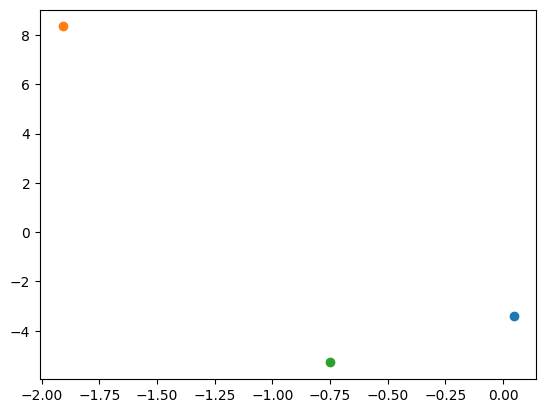

In [538]:
"""for i in range(3):
     plt.scatter(cent[i][0], cent[i][1])"""
kmeans.scatterplot_centroids()

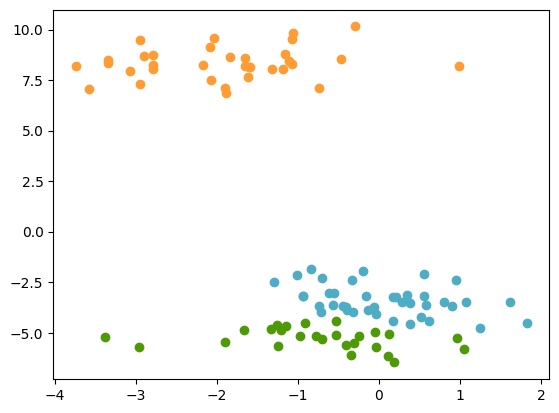

In [539]:
# kmeans.scatterplot_all()
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(x)):
        if kmeans._labels[j] == i:
            plt.scatter(x[j][0], x[j][1], c=colors[i])

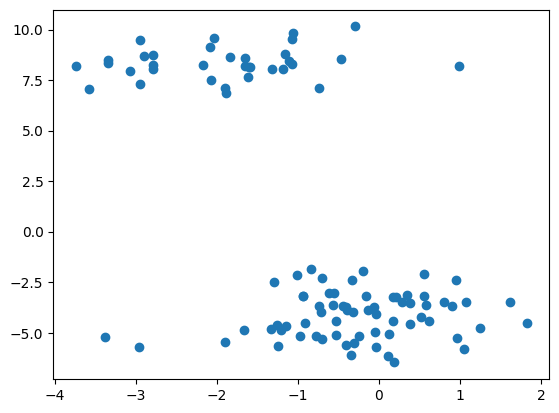

In [540]:
plt.scatter(x[:, 0], x[:, 1])

In [541]:
dist(kmeans.predict(x), kmeans.return_labels())
#print(len(kmeans.return_labels()), len(kmeans.predict(x)))

0.0

Comparando el gráfico con los datos iniciales, y este último gráfico con los datos ordenados en clusters por colores, se observa claramente que estos datos se han agrupado correctamente. Con ello, se puede afirmar el correcto funcionamiento de la clase de K-Means implementada.

# II. Preprocesado de Datos
En esta sección se preprocesa el dataset proporcionado, aplicando procesamiento de features de tipo One-hot-encoding y codificación ordinal, así como transformación de la dimensionalidad de los datos mediante PCA.

In [542]:
import pandas as pd
stars = pd.read_csv('Stars2.csv')
stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


In [543]:
stars.loc[0, 'Temperature']

3068

El primer paso, consiste en observar si hay datos perdidos en el conjunto de datos, es decir, buscaremos valores de "not a number".

In [544]:
stars.isna().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64

Se observa que no existen valores perdidos en el conjunto de los datos.

El siguiente paso consiste en observar la desviación típica de las variables numéricas.

In [545]:
stars.describe()

,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


Observamos que ningún valor de desviación estándar, o desviación típica (std), es igual a 0, por lo que ninguna de nuestras variables numéricas es constante, y por lo tanto no es procedente eliminar ninguno de los atributos de las estrellas.

A continuación, mediante el siguiente gráfico, se visualizan los valores de temperatura de las diferentes estrellas.

<Axes: >

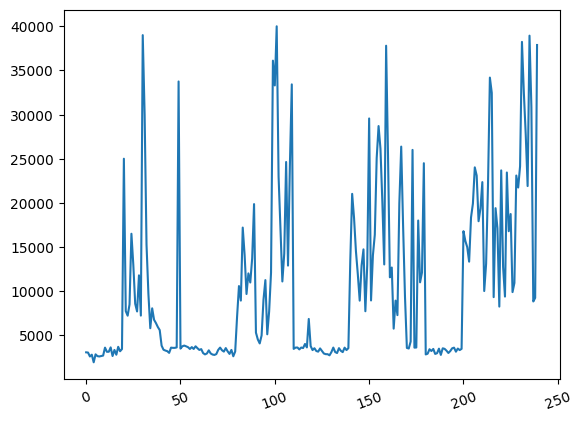

In [546]:
stars['Temperature'].plot(rot=20)

Se observan grandes diferencias entre la temperatura de muchas estrellas, puesto que estamos hablando de temperaturas de astros, con grandes diferencias en tamaño y situadas en puntos muy diferentes en el mapa. Esto además explica los altos valores de desviación típica observados anteriormente en la descripción de la variable de la temperatura.

Esta tendencia es beneficiosa en este caso, puesto que permitirá una buena clasificación de los datos. Por lo tanto, no es procedente eliminar instancias del dataset. Además, una vez se hayan clasificado los datos podría ser interesante comparar los resultados con este gráfico, observando los resultados de la clasificación y comprobando el nivel de ajuste con las desviaciones observadas en este gráfico.

Una vez se han preprocesado las instancias y los atributos, se observa que hay dos variables, 'Colors' y 'Spectral_Class' que son variables categóricas. Es importante transformarlas a variables numéricas. Antes de procesar su transformación, se debe llevar a cabo un preprocesado de los valores de estas variables.

En primer lugar, observamos los diferentes colores asociados a las estrellas

In [547]:
stars['Color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue-White'], dtype=object)

Podemos ver que algunos valores se repiten con ligeras diferencias en el nombre de la etiqueta. Por ejemplo, "yellowish" y "Yellowish" son la misma etiqueta pero con la primera letra escrita en minúscula y mayúscula respectivamente. Por lo tanto, modificamos los nombres de las etiquetas de color a minúsculas

In [548]:
stars['Color'] = stars['Color'].str.lower()
stars['Color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

También observamos que "blue-white" es la misma etiqueta que "blue white", con la diferencia del guión que separa las dos palabras, que en el primer caso está presente y en el segundo no. Algo similar ocurre con "yellow-white" y "white-yellow". Asumimos en estos dos casos que el valor del atributo es el mismo, y para ello modificamos el nombre de las etiquetas para que ninguna tenga guión y proponemos el orden "yellow white" para todos los casos. Asumimos también que hay una diferencia entre "yellowish white" y "yellow white", igual que hay diferencia entre "white" y "whitish", por lo que estos dos valores del atributo "Color" se mantienen como diferentes valores.

In [549]:
stars.loc[stars['Color']=='blue-white', 'Color'] = 'blue white'
stars.loc[stars['Color']=='white-yellow', 'Color'] = 'yellow white'
stars.loc[stars['Color']=='yellow-white', 'Color'] = 'yellow white'

In [550]:
stars['Color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'yellowish', 'orange-red'], dtype=object)

In [551]:
stars[stars['Color']=='blue white']

,Temperature,L,R,A_M,Color,Spectral_Class
20,25000,0.05600,0.00840,10.580,blue white,B
24,16500,0.01300,0.01400,11.890,blue white,B
26,8570,0.00081,0.00970,14.200,blue white,A
31,30000,28840.00000,6.30000,-4.200,blue white,B
32,15276,1136.00000,7.20000,-1.970,blue white,B
83,17200,0.00098,0.01500,12.450,blue white,B
84,14100,0.00067,0.00890,12.170,blue white,B
85,9675,0.00045,0.01090,13.980,blue white,A
86,12010,0.00078,0.00920,12.130,blue white,B
87,10980,0.00074,0.00870,11.190,blue white,B


A continuación, se preprocesan los valores del atributo 'Spectral_Class' para asegurar que todos ellos son correctos, mediante un proceso similar al realizado para el atirbuto 'Color'.

In [552]:
stars['Spectral_Class'].unique()

array(['M', 'B', 'A', 'F', 'O', 'K', 'G'], dtype=object)

Es fácilmente observable que todos los valores son correctos, se corresponden con la escala de valores proporcionada en el enunciado de esta práctica, y no se repiten ni presentan errores de nombramiento de las etiquetas, por lo que no es necesario realizar modificaciones en este atributo del dataframe.

Una vez se han preprocesado los atributos de la clase espectral y el color asociados a cada estrella de nuestro dataframe, se llevan a cabo dos técnicas para transformar los datos y poder trabajar con variables categóricas. 

En primer lugar, se llevará a cabo la técnica de "One-Hot-Encoding" de cada una de estas dos variables. A continuación, se llevará a cabo una transformación de las variables a atributos ordinales, de forma que se ordenan los colores según se atribuyan a mayor o menor temperatura, e igualmente para la variable de la clase espectral.

Para poder comparar los resultados arrojados por una técnica y otra, generamos dos copias de nuestro dataframe según el tratamiento de los datos

In [553]:
stars_1hot= stars.copy()
stars_ordinal= stars.copy()

## 1. One Hot Encoding
Se estudia la posibilidad de convertir las variables categóricas del dataset a vairables numéricas binarias mediante la técnica del One-Hot-Encoding, que genera una variable binaria para cada posible valor del atributo original.

In [554]:
#1. One Hot Encoding de color

for color in stars_1hot['Color'].unique():
    labels= []
    #Iteramos 1 vez por fila
    for i in stars_1hot['Color']:
        if i==color:
            labels.append(1)
        else:
            labels.append(0)
    stars_1hot[color]= labels

# se elimina el atributo inicial
stars_1hot = stars_1hot.drop(columns=["Color"])

stars_1hot

,Temperature,L,R,A_M,Spectral_Class,red,blue white,white,yellowish white,pale yellow orange,blue,whitish,yellow white,orange,yellowish,orange-red
0,3068,0.002400,0.1700,16.12,M,1,0,0,0,0,0,0,0,0,0,0
1,3042,0.000500,0.1542,16.60,M,1,0,0,0,0,0,0,0,0,0,0
2,2600,0.000300,0.1020,18.70,M,1,0,0,0,0,0,0,0,0,0,0
3,2800,0.000200,0.1600,16.65,M,1,0,0,0,0,0,0,0,0,0,0
4,1939,0.000138,0.1030,20.06,M,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,O,0,0,0,0,0,1,0,0,0,0,0
236,30839,834042.000000,1194.0000,-10.63,O,0,0,0,0,0,1,0,0,0,0,0
237,8829,537493.000000,1423.0000,-10.73,A,0,0,1,0,0,0,0,0,0,0,0
238,9235,404940.000000,1112.0000,-11.23,A,0,0,1,0,0,0,0,0,0,0,0


In [555]:
#2. One hot encoding de Clase espectral
for spectral in stars_1hot['Spectral_Class'].unique():
    labels= []
    #Iteramos 1 vez por fila
    for i in stars_1hot['Spectral_Class']:
        if i==spectral:
            labels.append(1)
        else:
            labels.append(0)
    stars_1hot[spectral]= labels

# se elimina el atributo inicial
stars_1hot = stars_1hot.drop(columns=["Spectral_Class"])
    
stars_1hot

,Temperature,L,R,A_M,red,blue white,white,yellowish white,pale yellow orange,blue,...,orange,yellowish,orange-red,M,B,A,F,O,K,G
0,3068,0.002400,0.1700,16.12,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3042,0.000500,0.1542,16.60,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2600,0.000300,0.1020,18.70,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2800,0.000200,0.1600,16.65,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1939,0.000138,0.1030,20.06,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
236,30839,834042.000000,1194.0000,-10.63,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
237,8829,537493.000000,1423.0000,-10.73,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
238,9235,404940.000000,1112.0000,-11.23,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## 2. Ordinal Scale Encoding
En esta segunda variante, convertimos las variables categóricas a escalas ordinales. 

In [556]:
# orden de clase espectral asociada a una estrella de menor a mayor energía
spectral_class=["M","K","G","F","A","B","O"]

In [557]:
labels= []

#Iteramos 1 vez por fila
for i in stars_ordinal['Spectral_Class']:
    labels.append(spectral_class.index(i))
       
stars_ordinal['Spectral_Class']= labels
    
stars_ordinal


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,red,0
1,3042,0.000500,0.1542,16.60,red,0
2,2600,0.000300,0.1020,18.70,red,0
3,2800,0.000200,0.1600,16.65,red,0
4,1939,0.000138,0.1030,20.06,red,0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,blue,6
236,30839,834042.000000,1194.0000,-10.63,blue,6
237,8829,537493.000000,1423.0000,-10.73,white,4
238,9235,404940.000000,1112.0000,-11.23,white,4


En el caso de los colores, debemos averiguar en primer lugar el orden, es decir, qué colores se asignan a las estrellas menos calientes y cuáles a las más caliente. Para ello, se ha decidido ordenar los colores según la temperatura media de todas las estrellas asociadas a un mismo color. A continuación se obtiene dicho orden, de colores con menor temperatura media a aquellos con mayor temperatura media.

In [558]:
color_means=[]

iter = 0
for color in stars_ordinal['Color'].unique():
    
    temp= stars_ordinal[stars_ordinal['Color']==color]['Temperature'].mean()
    
    # inserción del primer elemento
    if iter == 0:
        color_means.append({'Color': color, 'Temperature': temp})
    
    # inserción del resto, comprobando la posición de inserción
    else:
        inserted= False
        i=0
        while not inserted and i<len(color_means):
            if temp <= color_means[i]['Temperature']:
                color_means.insert(i, {'Color': color, 'Temperature': temp})
                inserted = True
            i+=1
        
        if not inserted:
            color_means.append({'Color': color, 'Temperature': temp})
            
    iter += 1 
    # print("array de medias actualizado: ", color_means)

colors = []
for i in range(len(color_means)):
    colors.append(color_means[i]['Color'])
print("Array of sorted colors", colors)


Array of sorted colors ['red', 'orange', 'yellowish', 'orange-red', 'yellow white', 'pale yellow orange', 'whitish', 'white', 'yellowish white', 'blue white', 'blue']


En base a ello se procede a asignar la etiqueta ordinal correspondiente al color de cada estrella.

In [559]:
labels= []

#Iteramos 1 vez por fila
for i in stars_ordinal['Color']:
    labels.append(colors.index(i))

stars_ordinal['Color']= labels
    
stars_ordinal


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0,0
1,3042,0.000500,0.1542,16.60,0,0
2,2600,0.000300,0.1020,18.70,0,0
3,2800,0.000200,0.1600,16.65,0,0
4,1939,0.000138,0.1030,20.06,0,0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,10,6
236,30839,834042.000000,1194.0000,-10.63,10,6
237,8829,537493.000000,1423.0000,-10.73,7,4
238,9235,404940.000000,1112.0000,-11.23,7,4


## 3.PCA
Para poder aplicar el algoritmo de clasificación y poder representar los datos correctamente se aplica un algoritmo de PCA, Análisis de Componentes Principales. Esto es necesario para reducir la dimensionalidad y permitir la correcta visualización de los datos clusterizados, ya que actualmente están formados por más de dos dimensiones (las dimensiones son los atributos).


In [560]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

En primer lugar se debe llevar a cabo un nuevo preprocesamiento de los datos para escalar las variables.

In [561]:
#features = stars_1hot.columns.tolist()
#features_ = stars_1hot[[features[0], features[1], features[2]]]

# con el dataset preprocesado con ordinal scaler
scaler = StandardScaler()
stars_ordinal_scaled= scaler.fit_transform(stars_ordinal[['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class']])
stars_ordinal_scaled

array([[-0.7793821 , -0.59862356, -0.45920992,  1.11674535, -0.99791525,
        -0.99778079],
       [-0.78210961, -0.59862357, -0.45924053,  1.16241376, -0.99791525,
        -0.99778079],
       [-0.82847728, -0.59862357, -0.45934168,  1.36221308, -0.99791525,
        -0.99778079],
       ...,
       [-0.17502879,  2.40315735,  2.29779992, -1.43783157,  0.54440087,
         0.58547468],
       [-0.13243767,  1.66287782,  1.69517694, -1.48540283,  0.54440087,
         0.58547468],
       [ 2.87275403,  1.04834522,  2.99536993, -1.15906395,  1.20539349,
         1.37710241]])

In [562]:
# con el dataset preprocesado con One Hot Encoding
stars_1hot_scaled = scaler.fit_transform(stars_1hot[['Temperature', 'L', 'R', 'A_M', 'red', 'blue white', 'white',
                                                    'yellowish white', 'pale yellow orange', 'blue', 'whitish', 
                                                    'yellow white', 'orange', 'yellowish', 'orange-red', 'M', 'B', 
                                                    'A', 'F', 'O', 'K', 'G']])
stars_1hot_scaled

array([[-0.7793821 , -0.59862356, -0.45920992, ..., -0.4472136 ,
        -0.16012815, -0.06468462],
       [-0.78210961, -0.59862357, -0.45924053, ..., -0.4472136 ,
        -0.16012815, -0.06468462],
       [-0.82847728, -0.59862357, -0.45934168, ..., -0.4472136 ,
        -0.16012815, -0.06468462],
       ...,
       [-0.17502879,  2.40315735,  2.29779992, ..., -0.4472136 ,
        -0.16012815, -0.06468462],
       [-0.13243767,  1.66287782,  1.69517694, ..., -0.4472136 ,
        -0.16012815, -0.06468462],
       [ 2.87275403,  1.04834522,  2.99536993, ...,  2.23606798,
        -0.16012815, -0.06468462]])

In [563]:
pca = PCA(n_components=2)
stars_ordinal_pca = pca.fit_transform(stars_ordinal_scaled)
stars_ordinal_pca

array([[-2.06232640e+00, -1.56093077e-01],
       [-2.08180617e+00, -1.74072026e-01],
       [-2.18325196e+00, -2.45291709e-01],
       [-2.09566249e+00, -1.70528450e-01],
       [-2.26746498e+00, -2.82903978e-01],
       [-2.10620662e+00, -1.84244806e-01],
       [-2.12533114e+00, -1.88910309e-01],
       [-2.13399145e+00, -1.95067426e-01],
       [-2.13340975e+00, -1.98112072e-01],
       [-2.07787945e+00, -1.45121749e-01],
       [-1.83014878e+00,  4.21164344e-02],
       [-1.89516090e+00,  1.00915301e-02],
       [-1.94878289e+00, -4.51109540e-02],
       [-1.82084534e+00,  4.94544621e-02],
       [-1.91861544e+00,  2.09347294e-02],
       [-1.93327937e+00, -4.43023337e-02],
       [-2.02522868e+00, -9.86359557e-02],
       [-1.82978221e+00,  3.57380567e-02],
       [-1.95804151e+00, -5.87854191e-02],
       [-1.85662961e+00,  2.65807922e-02],
       [ 1.12259104e+00, -1.75607382e+00],
       [-2.59886904e-01, -1.21994261e+00],
       [-4.85448812e-01, -1.09103034e+00],
       [-2.

In [564]:
stars_1hot_pca = pca.fit_transform(stars_1hot_scaled)
stars_1hot_pca

array([[-2.27313999,  0.36735406],
       [-2.28862741,  0.35600619],
       [-2.37084369,  0.30841039],
       [-2.30078195,  0.35631637],
       [-2.4405929 ,  0.27993763],
       [-2.30888679,  0.3481309 ],
       [-2.32499693,  0.34365347],
       [-2.33200981,  0.33955206],
       [-2.33129806,  0.3380519 ],
       [-2.2872693 ,  0.37129445],
       [-2.08742926,  0.4943468 ],
       [-2.14106492,  0.47083918],
       [-2.18329694,  0.43667734],
       [-2.07994346,  0.49913216],
       [-2.16197222,  0.47386402],
       [-2.17003089,  0.43877773],
       [-2.24526214,  0.4008844 ],
       [-2.08666923,  0.49111493],
       [-2.19030084,  0.42865064],
       [-2.10910089,  0.48349849],
       [ 1.29896822, -2.36697393],
       [-0.21818415, -2.5225268 ],
       [-0.44705681, -2.85188234],
       [-0.19903989, -2.53875299],
       [ 0.88534615, -2.3455108 ],
       [-0.25886924, -3.19619943],
       [ 0.12507042, -2.53731087],
       [-0.55884886, -3.21697538],
       [-0.32249241,

# III. Aplicación de Algoritmos de clustering 

In [565]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples


## 1. K-means
### A. Selección de número de clusters - Silhouette y Método del Codo
En primer lugar, es necesario escoger un número de clusters adecuado para especificar el hiperparámetro del modelo K-means. Para ello se emplea el método "del codo", que compara la inercia obtenida para un rango de posibles valores de n_clusters.

In [566]:
def elbow_method(data, init= 2, final= 8):
    """Calcula los coeficientes del método del codo para el rango de enteros init-final"""
    results= [] 
    for i in range(init, final+1): 
        kmeans = KMeans(n_clusters=i, random_state=55)  #Cada iteración se crea un número distinto de clústers.
        kmeans.fit(data)
        results.append(kmeans.inertia_)
    #Impresión del gráfico
    plt.plot(range(init, final +1 ), results)

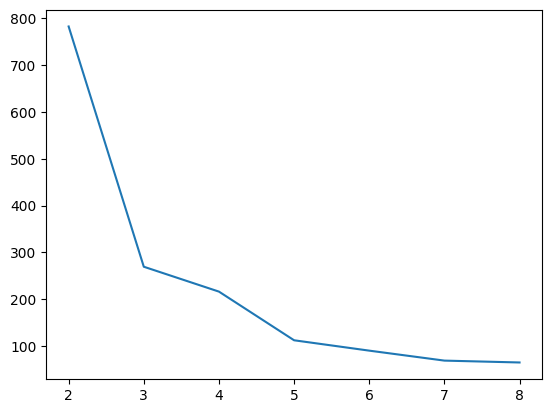

In [567]:
elbow_method(stars_1hot_pca)

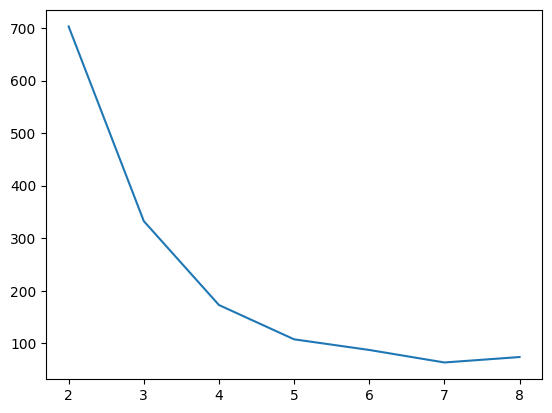

In [568]:
elbow_method(stars_ordinal_pca)

### Intepretación de resultados
Tras aplicar la función a ambos sets de datos, se pueden obsrvar ligeras difrencias en la gráfica obtenida. 
Para los datos tratados con one-hot-encoding, se observa una primera "punta" del codo para 3 clusters. A partir de aquí, comienza un descenso considerable de la variación marginal de la inercia, suavizando la curva para los valores más altos. 
Por otra parte, el codo obtenido para los datos ordinales presenta una curva menos marcada, con un extremo de codo entorno a los 4 o 5 clústers. 
 

### Método Silhouette
Para obtener una estimación más obusta del número adecuado de clusters, se recurre al coeficiente de silhouette, que medirá el grado de semejanza entre puntos de un mismo clúster y el grado de diferencia entre puntos de diferentes grupos. 

In [569]:
def silhouette_graphic(data,  n_clusters, colors):
    "Dibuja el gráfico del coeficiente de silhouette para el número de clusters indicado."
    #Función apoyada en la implementación de sklearn.
    fig,ax1 = plt.subplots(1, 1)
    fig.set_size_inches(6, 4)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
        
    kmeans = KMeans(n_clusters=n_clusters, random_state=55)  #Cada iteración se crea un número distinto de clústers.
    k_labels= kmeans.fit_predict(data)
    
    #Cálculo de coeficientes
    values=[]
    silhouette_avg= silhouette_score(data, k_labels)
    silhouette_scores= silhouette_samples(data, k_labels)
    y_low= 10
    #dibujo del gráfico para cada cluster
    for i in range(n_clusters):
        values=silhouette_scores[k_labels == i]
        values.sort()
        size= values.shape[0]
        ax1.fill_betweenx(
            np.arange(y_low, y_low + size),
            0,
             values,
            facecolor=colors[i],
            edgecolor= colors[i],
            alpha=0.7,
        )
        ax1.text(-0.05, y_low + 0.5 * size, str(i))
        y_low = y_low + size + 10
        
    #línea del coeficiente medio
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

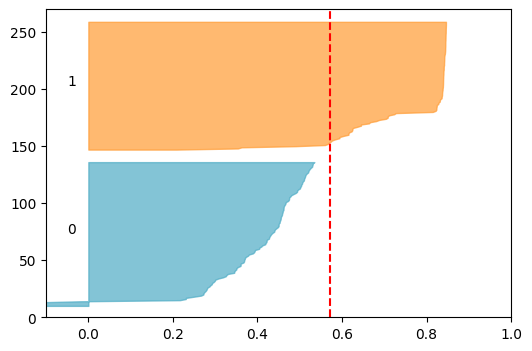

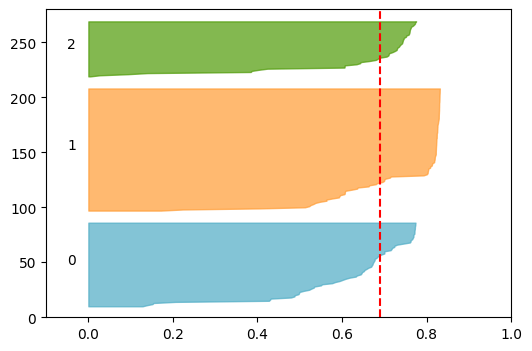

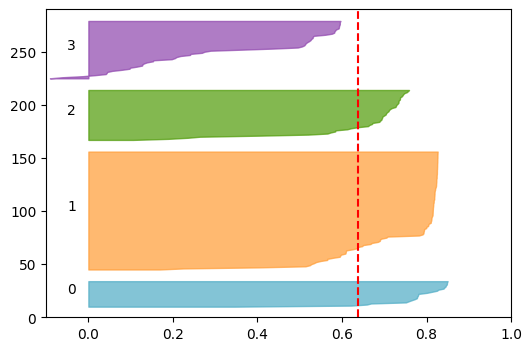

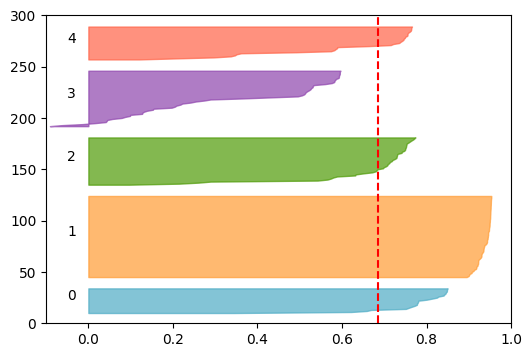

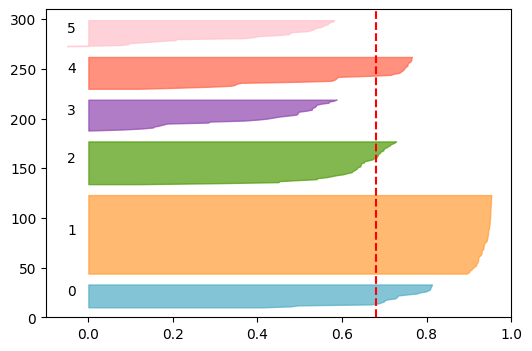

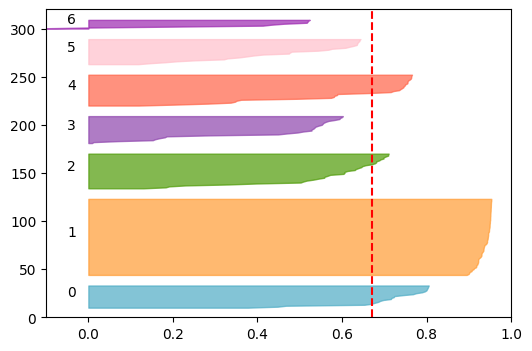

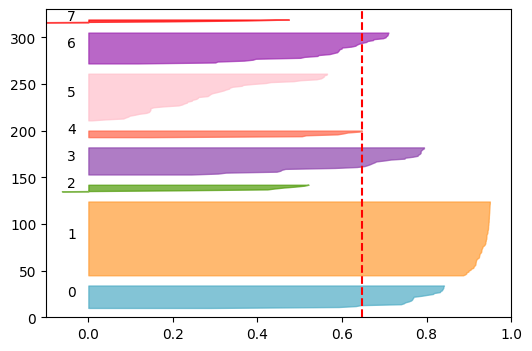

In [570]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06","#8E44AD", "#FF6347", "#FFC0CB", "#9C27B0", "#FF0000", "#CCCCCC" ]
def silhouette_method(data, init= 2, final= 8):
    """Calcula los coeficientes del método silhouette para el rango de enteros init-final y los muestra en un gráfico de área""" 
    for i in range(init, final+1):
         silhouette_graphic(data,  i, colors)
        
#llamada a la función
silhouette_method(stars_1hot_pca)
    

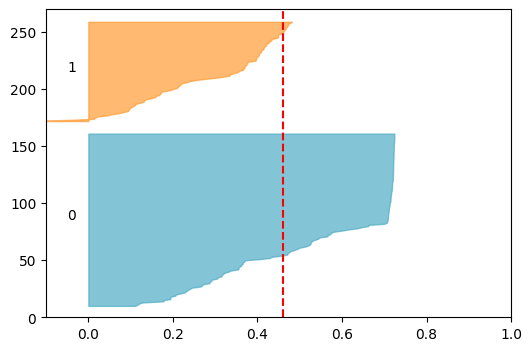

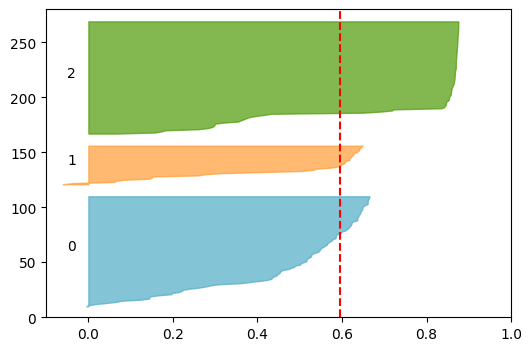

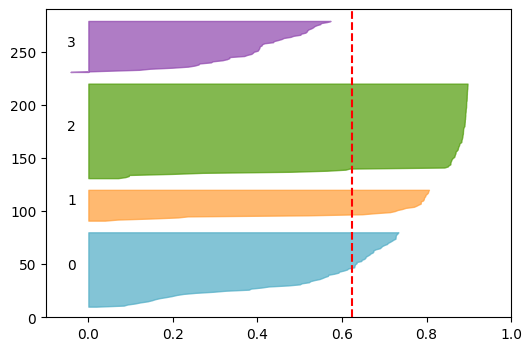

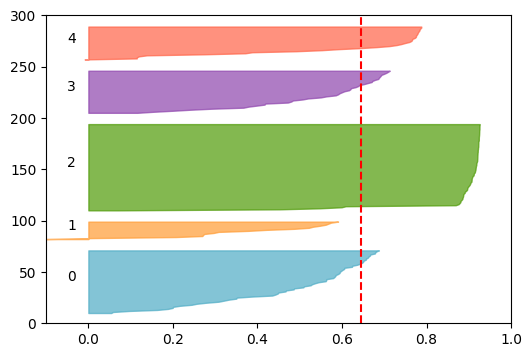

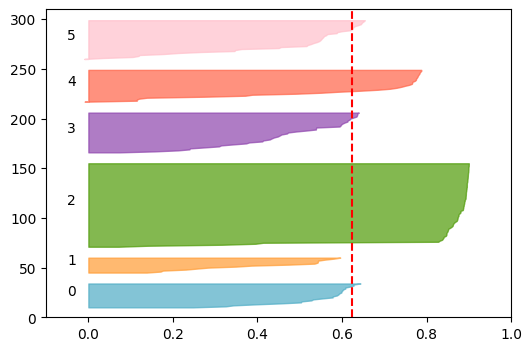

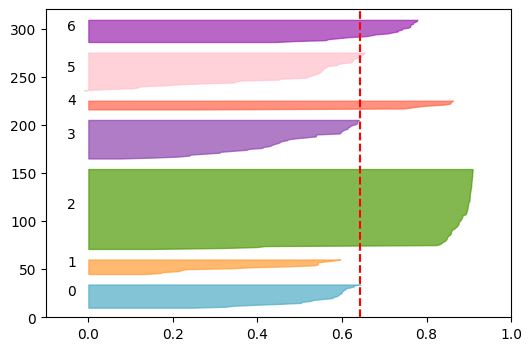

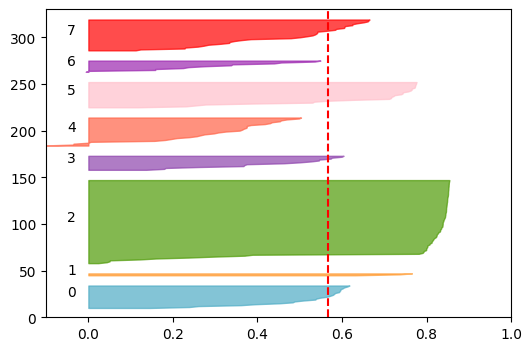

In [571]:
silhouette_method(stars_ordinal_pca)

COMENTAR RESULTADOS

### B. Aplicación de k-means

In [572]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06","#8E44AD", "#FF6347", "#FFC0CB"]
n_clusters_4 = 4
n_clusters_6 = 6

In [616]:
def kmeans_clustering(data, n):
    kmeans = KMeans(n_clusters=n, random_state=55)  # Número de clusters a crear
    kmeans.fit(data)
    results = {'labels': kmeans.labels_,
              'centroids': kmeans.cluster_centers_,
               'model': kmeans}
    return results

# Resultados para 4 clústers
time0= time.time()
km1hot_n4 = kmeans_clustering(stars_1hot_pca, 4)
print("K-Means (One-Hot Encoding) with 4 clusters:",np.bincount(km1hot_n4['labels']),
      "\nCentroides: ", km1hot_n4['centroids'])

time_km1hot_n4 = time.time() - time0
time0= time.time()

kmord_n4 = kmeans_clustering(stars_ordinal_pca, 4)
print("\nK-Means (Ordinal) with 4 clusters:", np.bincount(kmord_n4['labels']),
      "\nCentroides: ", kmord_n4['centroids'])

time_kmord_n4 = time.time() - time0
time0= time.time()

# Resultados para 6 clústers
km1hot_n6 = kmeans_clustering(stars_1hot_pca, 6)
print("\nK-Means (One-Hot Encoding) with 6 clusters:", np.bincount(km1hot_n6['labels']),
      "\nCentroides: ", km1hot_n6['centroids'])

time_km1hot_n6 = time.time() - time0
time0= time.time()

kmord_n6 = kmeans_clustering(stars_ordinal_pca, 6)
print("\nK-Means (Ordinal) with 6 clusters:", np.bincount(kmord_n6['labels']),
      "\nCentroides: ", kmord_n6['centroids'])

time_kmord_n6 = time.time() - time0

kmeans_times= [time_km1hot_n4, time_kmord_n4, time_km1hot_n6, time_kmord_n6]

K-Means (One-Hot Encoding) with 4 clusters: [ 25 112  48  55] 
Centroides:  [[-0.21918441 -2.79959676]
 [-1.86065017  0.84942474]
 [ 3.1445395   1.3644279 ]
 [ 1.14426425 -1.6479671 ]]

K-Means (Ordinal) with 4 clusters: [71 30 90 49] 
Centroides:  [[ 0.48854983 -1.18718846]
 [ 0.03722151  2.82869991]
 [-1.89911501 -0.02869647]
 [ 2.75748302  0.04106255]]

K-Means (One-Hot Encoding) with 6 clusters: [24 80 44 32 33 27] 
Centroides:  [[-0.23722281 -2.82635778]
 [-2.23800581  0.39253053]
 [ 3.21058377  1.42151404]
 [ 0.72341946 -2.00077366]
 [-0.86549641  2.04610666]
 [ 1.81037354 -1.09678654]]

K-Means (Ordinal) with 6 clusters: [25 16 85 41 33 40] 
Centroides:  [[-0.28491013 -0.93026702]
 [ 3.44330193  1.55439915]
 [-1.96458665 -0.10099218]
 [ 0.8137776  -1.3703621 ]
 [-0.21466454  2.61140141]
 [ 2.31847089 -0.57551941]]


In [574]:
def clustering_plot(n_clusters, data, colors, results):
    for i in range(n_clusters):
        for j in range(len(data)):
            if results['labels'][j] == i:
                plt.scatter(data[j][0], data[j][1], c=colors[i])
    for centroid in results['centroids']:
        plt.scatter(centroid[0], centroid[1], marker='*', s=100, c='black')

final silhouette score:  0.6367227423880405


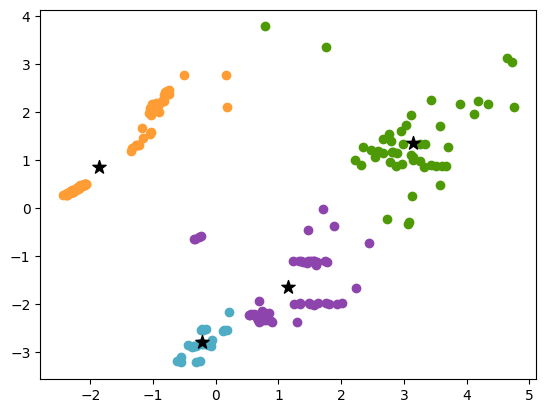

In [575]:
#1-hot n4 clustering plot
print("final silhouette score: ", silhouette_score(stars_1hot_pca, km1hot_n4['labels']))
clustering_plot(n_clusters_4, stars_1hot_pca, colors, km1hot_n4)

final silhouette score:  0.6232080616792594


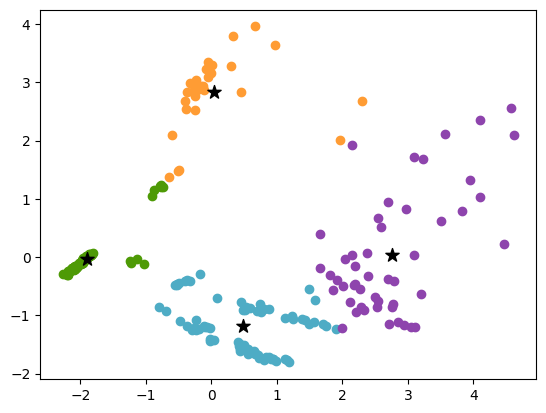

In [576]:
#Ordinal n4 clustering plot
print("final silhouette score: ", silhouette_score(stars_ordinal_pca, kmord_n4['labels']))
clustering_plot(n_clusters_4, stars_ordinal_pca, colors, kmord_n4)

final silhouette score:  0.6807196199752457


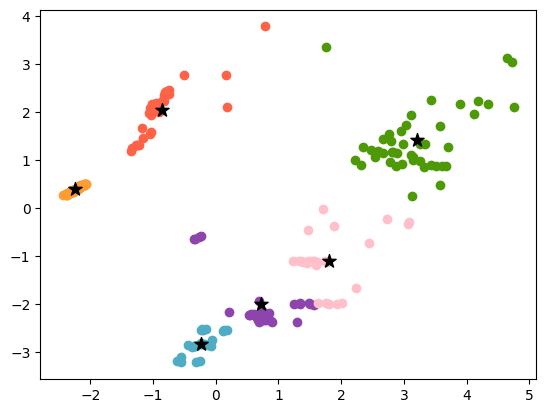

In [577]:
#1-hot n6 clustering plot
print("final silhouette score: ", silhouette_score(stars_1hot_pca, km1hot_n6['labels']))
clustering_plot(n_clusters_6, stars_1hot_pca, colors, km1hot_n6)

Creación de una función para imprimir el scatterplot de los resultados de los algoritmos de clustering.

final silhouette score:  0.6226913033460214


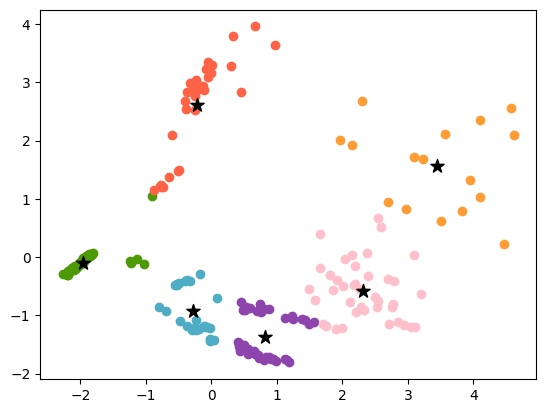

In [578]:
#Ordinal n6 clustering plot
print("final silhouette score: ", silhouette_score(stars_ordinal_pca, kmord_n6['labels']))
clustering_plot(n_clusters_6, stars_ordinal_pca, colors, kmord_n6)

### C. Discusión de resultados
**El mejor coeficiente lo presenta el clustering con 1-hot y 6 clústers.

## 2. Clustering Jerárquico
En este segundo método se emplea la técnica de clustering jerárquico para realizar la agrupación de los datos. 

In [579]:
# Algoritmo de Clustering Jerárquico
def hierarchical_clustering(data, n= None, dist=0):
    hierarchical = AgglomerativeClustering(distance_threshold=dist, n_clusters=n)  # Número de clusters a crear
    return hierarchical.fit(data)
def hierarchical_labels(data, n=None, dist=0):
    hierarchical = AgglomerativeClustering(distance_threshold=dist, n_clusters=n)  # Número de clusters a crear
    return hierarchical.fit(data).labels_


model_hier_c1Hot= hierarchical_clustering(stars_1hot_pca)
model_hier_ord=  hierarchical_clustering(stars_ordinal_pca)

#print("Clustering Jerárquico (One-Hot Encoding) with 4 clusters:", np.bincount(labels_hier_c1Hot))
#print("Clustering Jerárquico (Ordinal Encoding) with 4 clusters:", np.bincount(labels_hier_ord))


Una vez entrenado un modelo general y definidas las funciones para obtener el modelo y las etiquetas generadas, se imprime un gráfico mostrando la jerarquía creada por el algoritmo. 

In [580]:
#Generación de dendograma -implementación por sklearn.
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

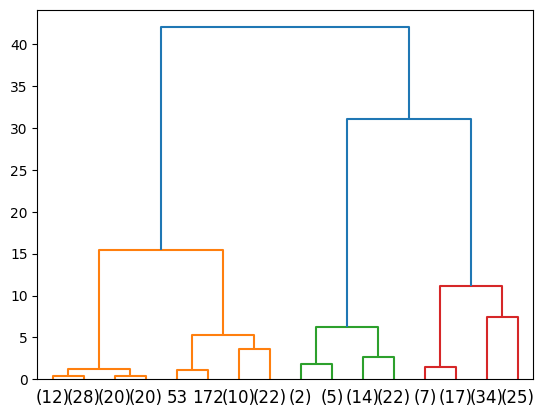

In [581]:
plot_dendrogram(model_hier_c1Hot, truncate_mode="level", p=3)

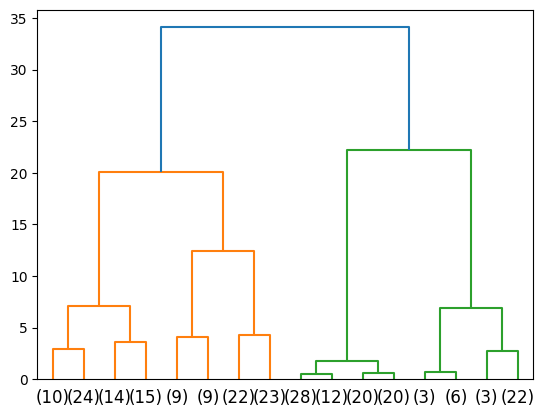

In [582]:
plot_dendrogram(model_hier_ord, truncate_mode="level", p=3)

Como se puede observar, y en concordancia con los resultados obtenidos para el algoritmo k-means, ejecutar el algoritmo con un número de clusters superior a 3 afina notablemente los resultados, proporcionando una clasificación mucho más precisa. 
A efectos de comparación con el método anterior se realizan las llamadas al método para 4 y 6 clusters.

In [583]:
def clustering_hier_plot(n_clusters, data, colors, results):
    for i in range(n_clusters):
        for j in range(len(data)):
            if results[j] == i:
                plt.scatter(data[j][0], data[j][1], c=colors[i])

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 1 1 2 0 0 0 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 0 2]
final silhouette score:  0.7118187213293983


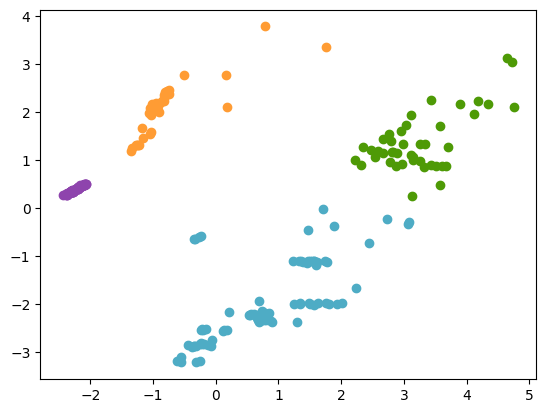

In [584]:
labels_hier_1Hot_n4 = hierarchical_labels(stars_1hot_pca, n_clusters_4, None)
print(labels_hier_1Hot_n4)

#1hot n4 hierarchical clustering plot
print("final silhouette score: ", silhouette_score(stars_1hot_pca, labels_hier_1Hot_n4))
clustering_hier_plot(n_clusters_4, stars_1hot_pca, colors, labels_hier_1Hot_n4)

final silhouette score:  0.6038380367281242


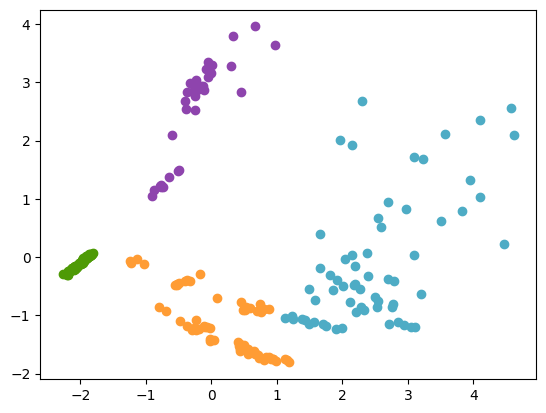

In [585]:
labels_hier_ord_n4= hierarchical_labels(stars_ordinal_pca, n_clusters_4, None)

#Ordinal n4 hierarchical clustering plot
print("final silhouette score: ", silhouette_score(stars_ordinal_pca, labels_hier_ord_n4))
clustering_hier_plot(n_clusters_4, stars_ordinal_pca, colors, labels_hier_ord_n4)

final silhouette score:  0.6839544890692569


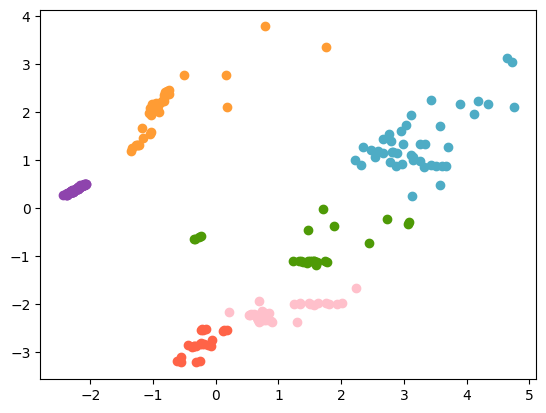

In [586]:
labels_hier_1Hot_n6= hierarchical_labels(stars_1hot_pca, 6, None)

#1hot n6 hierarchical clustering plot
print("final silhouette score: ", silhouette_score(stars_1hot_pca, labels_hier_1Hot_n6))
clustering_hier_plot(n_clusters_6, stars_1hot_pca, colors, labels_hier_1Hot_n6)

En esta sección se analizan varias combinaciones posibles de hiperparámetros para el algoritmo DBA. 
Puesto que se trata de un algoritmo no supervisado, es necesario recurrir a métodos alternativos de evaluación de los modelos que no requieran la existencia de etiquetas -al contrario que la acuracy o el error cometido. En este caso, y para simplificar la comparación entre modelos, se decide emplear el coeficiente silhouette de los resultados obtenidos, escogiendo aquel que optimice esta medida. 

final silhouette score:  0.6091047548491672


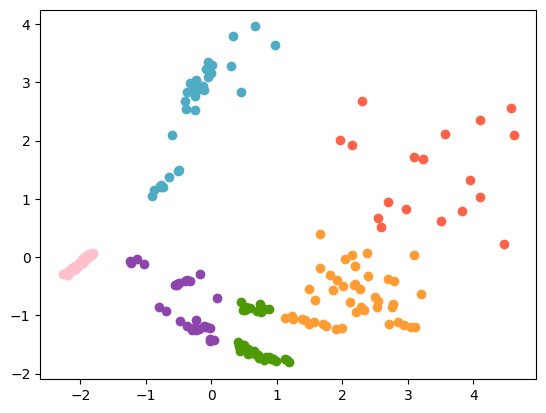

In [587]:
labels_hier_ord_n6= hierarchical_labels(stars_ordinal_pca, 6, None)

#Ordinal n6 hierarchical clustering plot
print("final silhouette score: ", silhouette_score(stars_ordinal_pca, labels_hier_ord_n6))
clustering_hier_plot(n_clusters_6, stars_ordinal_pca, colors, labels_hier_ord_n6)

### Discusión de resultados
**El mejor modelo resulta ser 1-hot con 4 clusters, con un silhouette de 0.71

## 3. DBA -Clustering por densidades
Finalmente, se implementa un último método de clustering basado en densidades. 
Para ello, se implementa una función de llamada y ejecución al algoritmo. Tras ellos, se realiza un pequeño ajuste de hiperparámetros y finalmente muestran mediante gráficas los resultados obtenidos para el mejor modelo. 

In [588]:
# Algoritmo de DBSCAN
def dbscan_clustering(data, eps, min):
    dbscan = DBSCAN(eps=eps, min_samples=min)  # Parámetros eps y min_samples
    return dbscan.fit(data).labels_

In [589]:
#Implemnetaión de optimización de hiperparámetros.
def hiper_opt_dbscan(data, range_eps, range_min):
    best_score= -2
    result= { 'labels': [],
              'score':  -1,
              'eps':   0,
              'min_n': 0 
              }
    
    for eps in range_eps:
        for min_n in range_min:
            label= dbscan_clustering(data, eps, min_n)
            silhouette= silhouette_score(data, label)
            #print("score for eps =", eps, " min_n = ", silhouette)
            if  silhouette > best_score:
                best_score= silhouette
                result['score'] = silhouette
                result['eps'] = eps
                result['min_n'] = min_n
                result ['labels'] = label
                           
    return result
        
        

In [590]:
best_dba_1hot= hiper_opt_dbscan(stars_1hot_pca, range_eps= map(lambda x: x/10.0, range(1,15, 1)), range_min= range (3,20,1))
print("La mejor combinación de 1hot será eps:", best_dba_1hot['eps'], ", min_n: ", best_dba_1hot['min_n'], "con una puntuación silhouette de: ", best_dba_1hot['score'])
best_dba_ord = hiper_opt_dbscan(stars_ordinal_pca, range_eps= map(lambda x: x/10.0, range(1,10, 1)), range_min= range (3,10,1))
print("La mejor combinación ordinal será eps:", best_dba_ord['eps'], ", min_n: ", best_dba_ord['min_n'],
      "con una puntuación silhouette de: ", best_dba_ord['score'])


La mejor combinación de 1hot será eps: 0.9 , min_n:  8 con una puntuación silhouette de:  0.7013123067321785
La mejor combinación ordinal será eps: 0.6 , min_n:  6 con una puntuación silhouette de:  0.6036482940251932


In [591]:
labels_dbscan_1hot = dbscan_clustering(stars_1hot_pca, best_dba_1hot['eps'], best_dba_1hot['min_n'])
labels_dbscan_ord = dbscan_clustering(stars_ordinal_pca, best_dba_ord['eps'], best_dba_ord['min_n'])

print("DBSCAN (One-Hot Encoding) dba :", labels_dbscan_1hot)
print("DBSCAN (Ordinal Encoding) dba :", labels_dbscan_ord)

DBSCAN (One-Hot Encoding) dba : [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  3
  3  2  3  3  3 -1  3  3  3  3  3  3  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1
 -1  1  1  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3 -1  3  3  3
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2
  2  2  3  3 -1  2  3  3  2  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2
  1  1  1  1  2  2  2  2  2  2  2  2  2  2  1  2 -1  2  2  2 -1  1  1  2]
DBSCAN (Ordinal Encoding) dba : [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  1  3  3  3 -1  3  3  3  3  3  3  0  0  0  0  0  0  0  

In [592]:
dba_cluster_values_1hot= set(labels_dbscan_1hot)
n_clusters_dba_1hot= len(dba_cluster_values_1hot)

dba_cluster_values_ord= set(labels_dbscan_ord)
n_clusters_dba_ord= len(dba_cluster_values_ord)

print("1-hot clusters:", n_clusters_dba_1hot, "; with values:", dba_cluster_values_1hot, "\n")
print("ordinal clusters:", n_clusters_dba_ord, "; with values:", dba_cluster_values_ord, "\n")

1-hot clusters: 5 ; with values: {0, 1, 2, 3, -1} 

ordinal clusters: 5 ; with values: {0, 1, 2, 3, -1} 


In [593]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06","#8E44AD", "#FF6347", "#FFC0CB", "#9C27B0" ]
def clustering_dba(n_clusters, data, colors, results):
    for i in range(n_clusters):
        for j in range(len(data)):
            if results[j] == i:
                plt.scatter(data[j][0], data[j][1], c=colors[i])

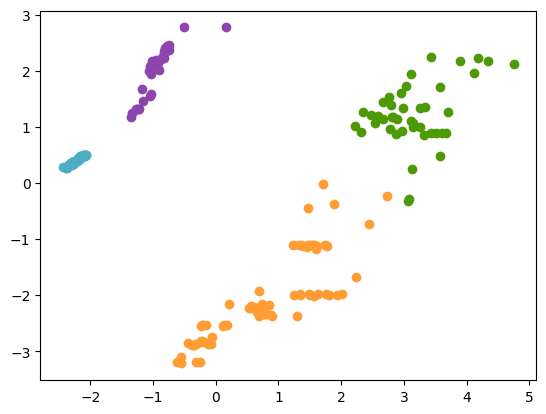

In [594]:
clustering_dba(n_clusters_dba_1hot, stars_1hot_pca, colors, labels_dbscan_1hot)


## 4. K-means implementación propia
Con el objetivo de poer comparar los resultados obtenidos con el algoritmo de KMeans de scikit-learn y el implementado por nosotras, se implementa un modelo adicional de clustering con este algoritmo definido y probado en la primera sección de este documento.

In [595]:
def kmeans_clustering_ours(data, n):
    kmeans_ours = KMeans_Ours(n_clusters=n, random_state=55)  # Número de clusters a crear
    kmeans_ours.fit(data)
    results = {'labels': kmeans_ours.return_labels(),
              'centroids': kmeans_ours.return_centroids()}
    return results

# Resultados para 4 clústers
time0= time.time()
kmours1hot_n4 = kmeans_clustering_ours(stars_1hot_pca, 4)
print("K-Means Ours (One-Hot Encoding) with 4 clusters:",np.bincount(kmours1hot_n4['labels']),
      "\nCentroides: ", kmours1hot_n4['centroids'])
time_kmours1hot_n4 = time.time() -time0
time0= time.time()
kmoursord_n4 = kmeans_clustering_ours(stars_ordinal_pca, 4)
print("\nK-Means Ours (Ordinal) with 4 clusters:", np.bincount(kmoursord_n4['labels']),
      "\nCentroides: ", kmoursord_n4['centroids'])
time_kmoursord_n4  = time.time() -time0
time0=time.time()
# Resultados para 6 clústers
kmours1hot_n6 = kmeans_clustering_ours(stars_1hot_pca, 6)
print("\nK-Means Ours (One-Hot Encoding) with 6 clusters:", np.bincount(kmours1hot_n6['labels']),
      "\nCentroides: ", kmours1hot_n6['centroids'])

time_kmours1hot_n6  = time.time() -time0
time0=time.time()

kmoursord_n6 = kmeans_clustering_ours(stars_ordinal_pca, 6)
print("\nK-Means Ours (Ordinal) with 6 clusters:", np.bincount(kmoursord_n6['labels']),
      "\nCentroides: ", kmoursord_n6['centroids'])

time_kmoursord_n6  = time.time() -time0
kmours_times= [time_kmours1hot_n4, time_kmoursord_n4, time_kmours1hot_n6, time_kmoursord_n6]

K-Means Ours (One-Hot Encoding) with 4 clusters: [50 80 33 77] 
Centroides:  [array([3.12388108, 1.21203213]), array([-2.23800581,  0.39253053]), array([-0.86549641,  2.04610666]), array([ 0.66763367, -2.07176064])]

K-Means Ours (Ordinal) with 4 clusters: [30 90 71 49] 
Centroides:  [array([0.03722151, 2.82869991]), array([-1.89911501, -0.02869647]), array([ 0.48854983, -1.18718846]), array([2.75748302, 0.04106255])]

K-Means Ours (One-Hot Encoding) with 6 clusters: [ 4 41 30 77 49 39] 
Centroides:  [array([0.72389524, 3.01126645]), array([-2.31755158,  0.33482105]), array([-0.98978399,  1.96143809]), array([ 0.66763367, -2.07176064]), array([3.15164512, 1.16805955]), array([-2.15438077,  0.45319948])]

K-Means Ours (Ordinal) with 6 clusters: [24 84 62 42 18 10] 
Centroides:  [array([-0.0377697 ,  3.07259382]), array([-1.9772298 , -0.11471567]), array([ 0.32876972, -1.20997081]), array([ 2.22534401, -0.68168393]), array([3.345868  , 1.44761133]), array([-0.70800191,  1.34857756])]


final silhouette score:  0.7276698222039911


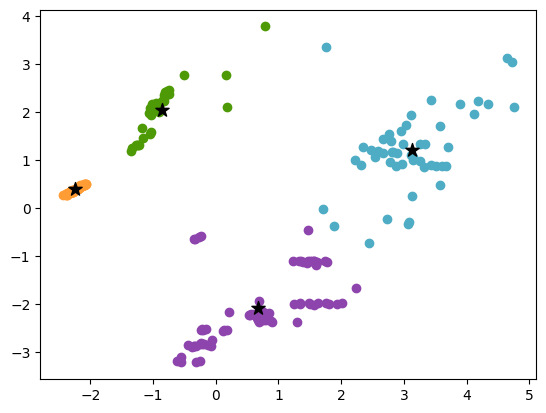

In [596]:
#1-hot n4 clustering plot - K-means ours

print("final silhouette score: ", silhouette_score(stars_1hot_pca, kmours1hot_n4['labels']))
clustering_plot(n_clusters_4, stars_1hot_pca, colors, kmours1hot_n4)


final silhouette score:  0.6232080616792594


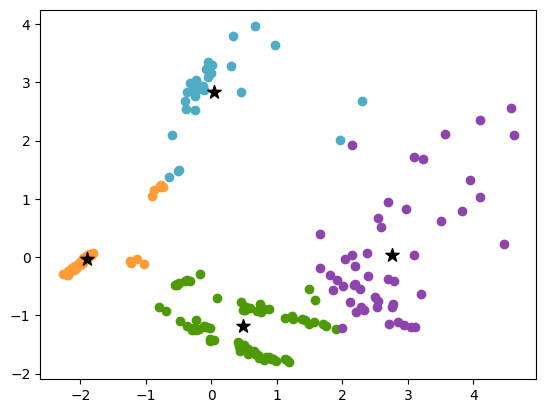

In [597]:
#Ordinal n4 clustering plot - K-means ours
print("final silhouette score: ", silhouette_score(stars_ordinal_pca, kmoursord_n4['labels']))
clustering_plot(n_clusters_4, stars_ordinal_pca, colors, kmoursord_n4)

final silhouette score:  0.622446180939658


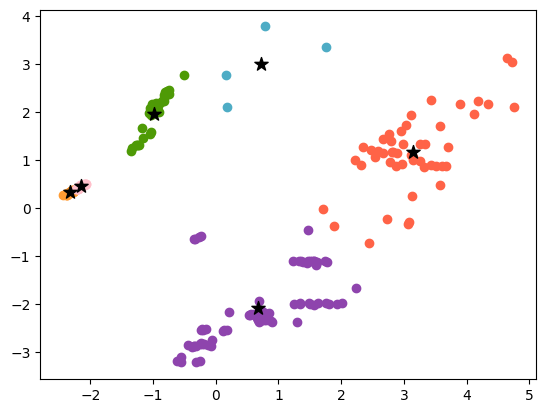

In [598]:
#1-hot n6 clustering plot - K-means ours
print("final silhouette score: ", silhouette_score(stars_1hot_pca, kmours1hot_n6['labels']))
clustering_plot(n_clusters_6, stars_1hot_pca, colors, kmours1hot_n6)

final silhouette score:  0.6529899150949362


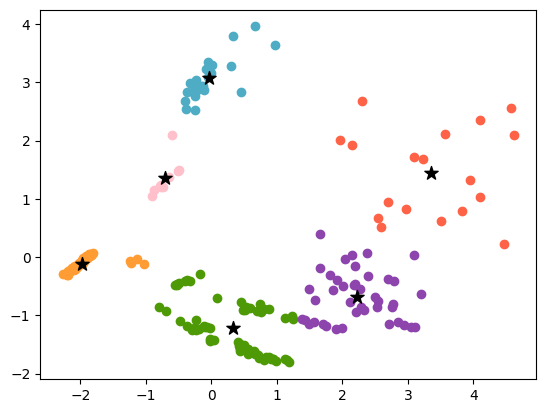

In [599]:
#Ordinal n6 clustering plot - K-means ours
print("final silhouette score: ", silhouette_score(stars_ordinal_pca, kmoursord_n6['labels']))
clustering_plot(n_clusters_6, stars_ordinal_pca, colors, kmoursord_n6)

# IV. Análisis de Resultados
En este último apartado se discute, de forma global, los resultados obtenidos para cada sección de este proyecto.
En primer lugar se crea un diccionario general en el que se recogen los resultados obtenidos para todos los modelos entrenados. A continuación, se transforman en un dataset pandas para permitir una visualización más clara. 


In [600]:
evaluation_metrics = {
    'kmeans_ordinal_4': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, kmord_n4['labels']), 
                   'n_clusters': n_clusters_4, 'eps': "-", 'min_n': "-", 'time': kmeans_times[0]}, 
    'kmeans_1hot_4': {'dataset': "1hot", 'silhouette': silhouette_score(stars_1hot_pca, km1hot_n4['labels']), 
                   'n_clusters': n_clusters_4, 'eps': "-", 'min_n': "-", 'time': kmeans_times[1]}, 
    'kmeans_ordinal_6': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, kmord_n6['labels']), 
                   'n_clusters': n_clusters_6, 'eps': "-", 'min_n': "-", 'time': kmeans_times[2]}, 
    'kmeans_1hot_6': {'dataset': "1hot", 'silhouette': silhouette_score(stars_1hot_pca, km1hot_n6['labels']), 
                   'n_clusters': n_clusters_6, 'eps': "-", 'min_n': "-", 'time': kmeans_times[3]}, 
    
    'kmeansOurs_ordinal_4': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, kmoursord_n4['labels']), 
                          'n_clusters': n_clusters_4, 'eps': "-", 'min_n': "-", 'time': kmours_times[0]}, 
    'kmeansOurs_1hot_4': {'dataset': "1hot", 'silhouette': silhouette_score(stars_1hot_pca, kmours1hot_n4['labels']), 
                           'n_clusters': n_clusters_4, 'eps': "-", 'min_n': "-", 'time': kmours_times[1]}, 
    'kmeansOurs_ordinal_6': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, kmoursord_n6['labels']), 
                          'n_clusters': n_clusters_6, 'eps': "-", 'min_n': "-", 'time': kmours_times[2]}, 
    'kmeansOurs_1hot_6': {'dataset': "1hot", 'silhouette': silhouette_score(stars_1hot_pca, kmours1hot_n6['labels']), 
                           'n_clusters': n_clusters_6, 'eps': "-", 'min_n': "-", 'time': kmours_times[3]}, 
    
    'hier_ordinal_4': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, labels_hier_ord_n4), 
                   'n_clusters': n_clusters_4, 'eps': "-", 'min_n': "-"},     
    'hier_1hot_4': {'dataset': "1hot", 'silhouette': silhouette_score(stars_1hot_pca, labels_hier_1Hot_n4), 
                  'n_clusters': n_clusters_4, 'eps': "-", 'min_n': "-"},
    'hier_ordinal_6': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, labels_hier_ord_n6), 
                   'n_clusters': n_clusters_6, 'eps': "-", 'min_n': "-"},     
    'hier_1hot_6': {'dataset': "1hot", 'silhouette': silhouette_score(stars_1hot_pca, labels_hier_1Hot_n6), 
                  'n_clusters': n_clusters_6, 'eps': "-", 'min_n': "-"},
    
    'dba_ordinal_5': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_ordinal_pca, labels_dbscan_ord), 
                'n_clusters': n_clusters_dba_ord, 'eps': best_dba_ord['eps'], 'min_n': best_dba_ord['min_n']},
    'dba_1hot_5': {'dataset': "ordinal", 'silhouette': silhouette_score(stars_1hot_pca, labels_dbscan_1hot), 
                 'n_clusters': n_clusters_dba_1hot, 'eps': best_dba_ord['eps'], 'min_n': best_dba_ord['min_n']}
}
#evaluation_metrics

In [601]:
df= pd.DataFrame(evaluation_metrics, index=evaluation_metrics['kmeans_1hot_4'].keys())
results= df.transpose()
results

,dataset,silhouette,n_clusters,eps,min_n,time
kmeans_ordinal_4,ordinal,0.623208,4,-,-,0.014796
kmeans_1hot_4,1hot,0.636723,4,-,-,0.016882
kmeans_ordinal_6,ordinal,0.622691,6,-,-,0.016955
kmeans_1hot_6,1hot,0.68072,6,-,-,0.018142
kmeansOurs_ordinal_4,ordinal,0.623208,4,-,-,0.071459
kmeansOurs_1hot_4,1hot,0.72767,4,-,-,0.096884
kmeansOurs_ordinal_6,ordinal,0.65299,6,-,-,0.070212
kmeansOurs_1hot_6,1hot,0.622446,6,-,-,0.205006
hier_ordinal_4,ordinal,0.603838,4,-,-,NaN
hier_1hot_4,1hot,0.711819,4,-,-,NaN


## A. Discusión Kmeans-Ours
Podemos comparar la implementación de kmeans diseñada en dos aspectos fundamentales: calidad de la agrupación y eficiencia. 
Para la primera, se emplea el coeficiente de silhouette calculado. Como puede observarse, los resultados para ambas versiones son my similares, con una variación máxima de 0.03 décimas. En el aspecto de eficiencia, medido a través dl tiempo de ejecución, las diferencias son más notable, con la implementación de sklearn demostrando una mayor rapidez para todas las combinaciones probadas. Estos resultaos pueden observarse en detalle en las gráficas proporconadas.

En base a los datos obtenidos, se concluye que la implementación de kmeans realizada ha sido, en general, capaz de emular los resultados del algoritmo original para el número de clusters óptimo. Sin embargo, la gran diferencia de rendimiento, especialmente en términos relativos, indica que sería conveniente mejorar su eficiencia si se quiere simular de fomra más precisa el comportamiento de la implementación de sklearn.


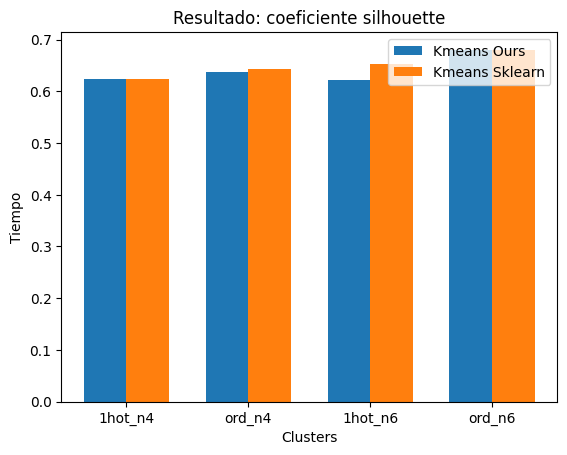

In [602]:
# Análisis de eficiencia


datos1 = [0.623208, 0.636723, 0.622691, 0.68072]
datos2 = [0.623208, 0.642305, 0.65299, 0.68072]


# Ancho de las barras
ancho = 0.35

fig, ax = plt.subplots()
indices= range(len(datos1))
# Agregar barras para los datos 1
bar1 = ax.bar(indices, datos1, ancho, label='Kmeans Ours')

# Agregar barras para los datos 2
bar2 = ax.bar([i + ancho for i in indices], datos2, ancho, label='Kmeans Sklearn')

# Etiquetas, título y leyenda
ax.set_xlabel('Clusters')
ax.set_ylabel('Tiempo')
ax.set_title('Resultado: coeficiente silhouette')
ax.set_xticks([i + ancho / 2 for i in indices])
ax.set_xticklabels(["1hot_n4", "ord_n4", "1hot_n6", "ord_n6"])
ax.legend()

# Mostrar gráfico
plt.show()

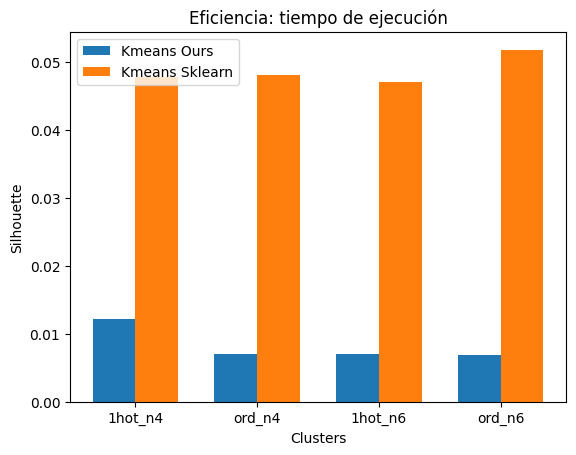

In [603]:
# Análisis de eficiencia
datos1 = [0.012125, 0.007057, 0.007026, 0.006845]
datos2 = [0.047842, 0.048055, 0.047103, 0.051823]


# Ancho de las barras
ancho = 0.35

# Crear la figura y los ejes
fig, ax = plt.subplots()
indices= range(len(datos1))

# Agregar barras para los datos 1
bar1 = ax.bar(indices, datos1, ancho, label='Kmeans Ours')

# Agregar barras para los datos 2
bar2 = ax.bar([i + ancho for i in indices], datos2, ancho, label='Kmeans Sklearn')

# Etiquetas, título y leyenda
ax.set_xlabel('Clusters')
ax.set_ylabel('Silhouette')
ax.set_title('Eficiencia: tiempo de ejecución')
ax.set_xticks([i + ancho / 2 for i in indices])
ax.set_xticklabels(["1hot_n4", "ord_n4", "1hot_n6", "ord_n6"])
ax.legend()

# Mostrar gráfico
plt.show()

## B. Preprocesado: One-hot-encoding vs. Ordinal Encoding
En segundo lugar, se comparan los resultados obtenidos para las dos opciones de preprocesado planteadas: 1-hot encoding y ordinal encoding.
Durante el desarrollo de la práctica se ha observado, de forma general, unos resultados más precisos con el método 1hot-encoding. Si bien en esta sección se muestran estas diferencias de forma gráfica para una apreciación más precisa y visual.



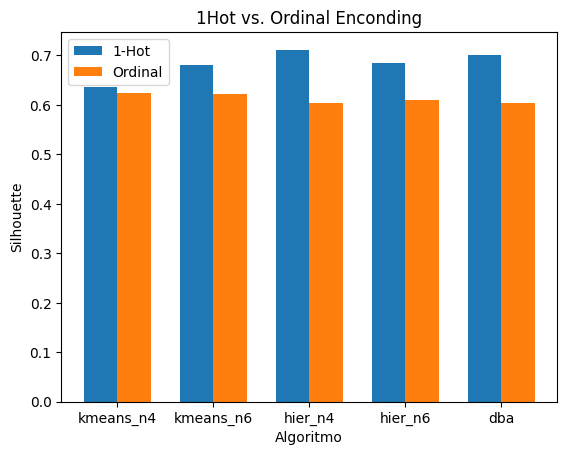

In [604]:
# Análisis de eficiencia
datos1 = [0.636723, 0.68072,  0.711819, 0.683954, 0.701312]
datos2 = [0.623208, 0.622691, 0.603838, 0.609105, 0.603648]


# Ancho de las barras
ancho = 0.35

# Crear la figura y los ejes
fig, ax = plt.subplots()
indices= range(len(datos1))

# Agregar barras para los datos 1
bar1 = ax.bar(indices, datos1, ancho, label='1-Hot')

# Agregar barras para los datos 2
bar2 = ax.bar([i + ancho for i in indices], datos2, ancho, label='Ordinal')

# Etiquetas, título y leyenda
ax.set_xlabel('Algoritmo')
ax.set_ylabel('Silhouette')
ax.set_title('1Hot vs. Ordinal Enconding')
ax.set_xticks([i + ancho / 2 for i in indices])
ax.set_xticklabels(["kmeans_n4", "kmeans_n6", "hier_n4", "hier_n6", "dba"])
ax.legend()

# Mostrar gráfico
plt.show()

Como puede verse, para cada uno de los métodos implementados, y con independencia del número de clusters, 1-hot consigue superar en coeficiente silhouette a la codificación ordinal. Por ello, se considera que, para el problema de clustering planteado y los datos proporcionados, será más conveniente emplear el método de 1-hot encoding para tratar las variables categóricas.

## C. Selección del algoritmo de clustering
De nuevo, y habiendo seleccionado la codificación 1-hot , es posible emplear el mismo gráfico para seleccionar el algoritmo que maximiza la métrica empleada -en este caso, el Kmeans con codificación 1-hot y 4 clústers, con un valor silhouette de 0.728.
Puesto que se ha seguido el mismo proceso de preprocesado para todos los algoritmos, el pipeline final recomendado será

In [ ]:
#Partiendo de stars-1hot...(paso 1)

# paso 2: escalador
scaler = StandardScaler()
stars_final_scaled = scaler.fit_transform(stars_1hot[['Temperature', 'L', 'R', 'A_M', 'red', 'blue white', 'white',
                                                    'yellowish white', 'pale yellow orange', 'blue', 'whitish', 
                                                    'yellow white', 'orange', 'yellowish', 'orange-red', 'M', 'B', 
                                                    'A', 'F', 'O', 'K', 'G']])
# Paso 3: redimensionado con PCA
pca = PCA(n_components=2)
stars_final_pca = pca.fit_transform(stars_final_scaled)

# Paso 4: aplicar kmeans
kmeans_final = kmeans_clustering(stars_final_pca, 4)
print("K-Means (One-Hot Encoding) with 4 clusters:",np.bincount(kmeans_final['labels']),
      "\nCentroides: ", kmeans_final['centroids'])


## D. Comparación con la agrupación standard
Finalmente, empleamos el modelo seleccionado para evaluar la similitud con la clasificación realista de estrellas propuesta. En este caso emplearemos el kmeans de 6 clusters, con el objetivo de facilitar la comparación con las categorías propuestas.  

In [633]:
#Codificación de los datos de la tabla de estrellas
standard_stars= {
    "enana_roja": [3000, 0.0007, 0.1, 17.5, 1, 0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0],
    "enana marrón": [3300, 0.0055, 0.35, 12.5, 1, 0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
    "enana blanca": [14000, 0.0025, 0.01, 12.6,0, 0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1],
    "estrella_principal": [16000, 32000, 4.4, -0.4, 0, 0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0],
    "supergigante": [15000, 300000, 50, -6.4, 0, 0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0 ],
    "hipergigante": [11000, 300000, 1400, -9.6, 0, 0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0 ]}

# Definir las etiquetas para cada valor
labels = ['Temperature', 'L', 'R', 'A_M', 'red', 'blue white', 'white', 'yellowish white', 'pale yellow orange', 'blue',
          'whitish', 'yellow white', 'orange', 'yellowish', 'orange-red', 'M', 'B', 'A', 'F', 'O', 'K', 'G']

# Convertir el diccionario en un DataFrame
standard_stars = pd.DataFrame(standard_stars, index=labels).T


standard_stars


,Temperature,L,R,A_M,red,blue white,white,yellowish white,pale yellow orange,blue,...,orange,yellowish,orange-red,M,B,A,F,O,K,G
enana_roja,3000.0,0.0007,0.10,17.5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
enana marrón,3300.0,0.0055,0.35,12.5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
enana blanca,14000.0,0.0025,0.01,12.6,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
estrella_principal,16000.0,32000.0000,4.40,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
supergigante,15000.0,300000.0000,50.00,-6.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
hipergigante,11000.0,300000.0000,1400.00,-9.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [634]:
kmeans_final6 = kmeans_clustering(stars_final_pca, 6)
print("K-Means (One-Hot Encoding) with 6 clusters:",np.bincount(kmeans_final6['labels']),
      "\nCentroides: ", kmeans_final6['centroids'])

K-Means (One-Hot Encoding) with 6 clusters: [1 1 1 1 1 1] 
Centroides:  [[ 3.48366325e+00 -1.09692635e+00]
 [-1.20549234e+00  7.28100838e-03]
 [ 2.25888122e-03  4.25170221e+00]
 [-2.68159442e+00 -1.75012996e+00]
 [ 2.45696697e+00 -8.36578603e-01]
 [-2.05580233e+00 -5.75348303e-01]]


In [635]:
# paso 2: escalador

standard_stars = scaler.fit_transform(standard_stars[['Temperature', 'L', 'R', 'A_M', 'red', 'blue white', 'white',
                                                    'yellowish white', 'pale yellow orange', 'blue', 'whitish', 
                                                    'yellow white', 'orange', 'yellowish', 'orange-red', 'M', 'B', 
                                                    'A', 'F', 'O', 'K', 'G']])
# Paso 3: redimensionado con PCA
standard_stars = pca.fit_transform(standard_stars)
kmeans_final6['model'].predict(standard_stars)

array([0, 4, 2, 1, 5, 3])